In [49]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.python.data import Dataset
import db
import sys
import pymongo
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras import initializers
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

myclient = pymongo.MongoClient("mongodb://localhost:27017/")
transferdb = myclient["transferdb"]

collfalse = transferdb["synfalse_transfers"]
colltrue = transferdb["true_transfers"]
df_false = pd.DataFrame(list(collfalse.find()))
df_true = pd.DataFrame(list(colltrue.find()))


# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

In [50]:
def preprocess_features(df):
    selected_features = df["tweet_text"].tolist()
    return selected_features

def preprocess_targets(df):
    output_targets = pd.DataFrame()
    output_targets["label_int"] = (df["label"] == "True").astype(float)
    return output_targets["label_int"].tolist()
    

    
    

In [162]:
# making the training sets
shuffeled_true = df_true.sample(frac=1)
shuffeled_false = df_false.sample(frac=1)
shuffeled = pd.concat([shuffeled_true.head(10000), shuffeled_false]).sample(frac=1)
training_examples = preprocess_features(shuffeled.head(10000))
training_targets = preprocess_targets(shuffeled.head(10000))

validation_examples = preprocess_features(shuffeled.tail(4000))
validation_targets = preprocess_targets(shuffeled.tail(4000))





In [52]:
print("Training examples summary:")
display.display(training_examples)
print("Validation examples summary:")
display.display(validation_examples)

print("Training targets summary:")
display.display(training_targets)
print("Validation targets summary:")
display.display(validation_targets)

Training examples summary:


[u'Robert Lewandowski has signed for Inter from Liverpool on #FFL pic.twitter.com/0Irux0JaSE',
 u'Chelsea transfer news: Inter Milan to attempt signing of Tiemoue Bakayoko https:// footballsfirst.com/2018/07/23/che lsea-transfer-news-inter-milan-to-attempt-signing-of-tiemoue-bakayoko/?utm_campaign=twitter&utm_medium=twitter&utm_source=twitter \u2026',
 u'If @manutd signs Marco Verratti , I will jump out of a moving truck. Or car. #mufc',
 u'Milan have closed a deal with Chelsea to acquire their midfielder Tiemoue Bakayoko on loan with an option to buy. He could arrive in Italy tomorrow. ( | @DiMarzio )',
 u'Pretty obvious Chelsea have not signed Jorginho today as that Italian report insinuated.',
 u'Sarri confirms it will be impossible for Real Madrid to sign #Hazard from #cfc now: http:// bit.ly/2MiAQgf',
 u'Watford Close to Securing Permanent Gerard Deulofeu Transfer as Barcelona Agree\u2026 https:// goo.gl/fb/Bv5YiJ #WatfordFC',
 u"Lucas Torreira hasn't even signed for Arsenal and t

Validation examples summary:


[u'Omg. Barca are sellin dani alves. Arsenal has signed morata . Immobile is nw Dortmunds No 9. Wow. I cnt wait fr nxt season',
 u'Everton close in on Chelsea\u2019s Kurt Zouma http:// bit.ly/2ATM7Py #Football , #Transfers , #CFC , #EFC pic.twitter.com/lOz88vNVKe',
 u"Thiago Silva has signed a contract extension at Paris St Germain. The signing will end Barcelona 's pursuit of the... http:// fb.me/28Uwj7jsa",
 u'Transfer Rumors: Will Sergio Ramos To Be A Part Of Manchester United ? http://www. sportsnewsupdated.com/soccer/2015/08 /26/transfer-rumors-will-sergio-ramos-to-be-a-part-of-manchester-united/ \u2026',
 u'Five reasons Arsenal WILL sign Karim Benzema or Robert Lewandowski this summer, including Chelsea fa... http:// bit.ly/1DYUHmi #Bundesliga',
 u'Manchester United transfer news: Jose Mourinho registers late interest in Riyad Mahrez as Gareth Bale told to .. http:// dld.bz/gczSB',
 u'Transfer news LIVE: The latest on standout loan star Demetri Mitchell returning to Hearts #HMFC 

Training targets summary:


[0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0

Validation targets summary:


[0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0

In [53]:
def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

In [54]:
ndarr = np.array(training_targets)


x_train, x_val = ngram_vectorize(training_examples, training_targets, validation_examples)
print(x_val)

  (0, 1185)	0.19960971
  (0, 1543)	0.12631865
  (0, 1670)	0.109920226
  (0, 1715)	0.34279418
  (0, 2155)	0.22664131
  (0, 4174)	0.2025343
  (0, 4175)	0.2025343
  (0, 5764)	0.30829406
  (0, 6482)	0.1429618
  (0, 6516)	0.20167705
  (0, 7427)	0.120839916
  (0, 9566)	0.1620592
  (0, 10132)	0.203855
  (0, 10506)	0.32199448
  (0, 12224)	0.1684697
  (0, 12620)	0.15987459
  (0, 12641)	0.33108038
  (0, 15388)	0.2564617
  (0, 16110)	0.33108038
  (1, 2608)	0.12893356
  (1, 2610)	0.12965705
  (1, 3194)	0.17738199
  (1, 3198)	0.31471434
  (1, 3269)	0.09085128
  (1, 3349)	0.2792493
  :	:
  (999, 3330)	0.23719473
  (999, 5428)	0.116291754
  (999, 5459)	0.25264242
  (999, 5975)	0.22495773
  (999, 5976)	0.22804542
  (999, 6954)	0.06304898
  (999, 6965)	0.1193983
  (999, 7667)	0.22804542
  (999, 7668)	0.22969623
  (999, 8422)	0.15191379
  (999, 8432)	0.20265093
  (999, 8687)	0.11434037
  (999, 8737)	0.2885401
  (999, 8945)	0.12985957
  (999, 8957)	0.15405332
  (999, 12873)	0.20683058
  (999, 14096)	0.09

In [55]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [56]:
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model


In [75]:
def plot_res(history):
    
    plt.ylabel("Accuracy")
    plt.xlabel("Periods")
    plt.title("Training & Validation Accuracy")
    plt.tight_layout()
    plt.plot(history['acc'], label="training")
    plt.plot(history['val_acc'], label="validation")
    plt.legend()
    plt.show()
    
    

In [106]:
def plot_loss(history):
    plt.ylabel("Loss")
    plt.xlabel("Periods")
    plt.title("Training & Validation Loss")
    plt.tight_layout()
    plt.plot(history['loss'], label="training")
    plt.plot(history['val_loss'], label="validation")
    plt.legend()
    plt.show()
    

In [174]:
def roc_curve(history):
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
        validation_targets[0:len(history["val_acc"])], history['val_acc'])
    plt.plot(false_positive_rate, true_positive_rate, label="our model")
    plt.plot([0, 1], [0, 1], label="random classifier")
    _ = plt.legend(loc=2)
    plt.show()

In [77]:
def calculate_auc(history):
    auc = metrics.roc_auc_score(validation_targets[0:len(history["val_acc"])], history['val_acc'])
    return auc
    

In [178]:
def train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=6,
                      units=64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
#     num_classes = explore_data.get_num_classes(train_labels)
    num_classes = 2
#     unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
#     if len(unexpected_labels):
#         raise ValueError('Unexpected label values found in the validation set:'
#                          ' {unexpected_labels}. Please make sure that the '
#                          'labels in the validation set are in the same range '
#                          'as training labels.'.format(
#                              unexpected_labels=unexpected_labels))

    # Vectorize texts.
    ndarr = np.array(train_labels)
    x_train, x_val = ngram_vectorize(
        train_texts, train_labels, val_texts)

    # Create model instance.
    model = mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=x_train.shape[1:],
                                  num_classes=num_classes)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
#     print('Validation accuracy: {acc}, loss: {loss}'.format(
#             acc=history['val_acc'][-1], loss=history['val_loss'][-1]))
    
    # Compute training and validation loss.
    
    # Plot Results
    plot_res(history)
    roc_curve(history)
    plot_loss(history)
    auc_score = calculate_auc(history)
    # Save model.
    model.save('twitter_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1], auc_score

Train on 10000 samples, validate on 4000 samples
Epoch 1/20
 - 7s - loss: 0.6585 - acc: 0.5822 - val_loss: 0.5157 - val_acc: 0.8595
Epoch 2/20
 - 4s - loss: 0.4171 - acc: 0.8462 - val_loss: 0.2148 - val_acc: 0.9805
Epoch 3/20
 - 3s - loss: 0.2651 - acc: 0.9474 - val_loss: 0.1293 - val_acc: 0.9818
Epoch 4/20
 - 3s - loss: 0.2014 - acc: 0.9639 - val_loss: 0.0954 - val_acc: 0.9843
Epoch 5/20
 - 3s - loss: 0.1716 - acc: 0.9680 - val_loss: 0.0805 - val_acc: 0.9872
Epoch 6/20
 - 3s - loss: 0.1612 - acc: 0.9681 - val_loss: 0.0688 - val_acc: 0.9890
Epoch 7/20
 - 3s - loss: 0.1405 - acc: 0.9739 - val_loss: 0.0635 - val_acc: 0.9898
Epoch 8/20
 - 3s - loss: 0.1269 - acc: 0.9775 - val_loss: 0.0622 - val_acc: 0.9898
Epoch 9/20
 - 3s - loss: 0.1186 - acc: 0.9772 - val_loss: 0.0575 - val_acc: 0.9898
Epoch 10/20
 - 3s - loss: 0.1150 - acc: 0.9772 - val_loss: 0.0674 - val_acc: 0.9887
Epoch 11/20
 - 4s - loss: 0.1092 - acc: 0.9789 - val_loss: 0.0599 - val_acc: 0.9898
Epoch 12/20
 - 3s - loss: 0.1041 - a

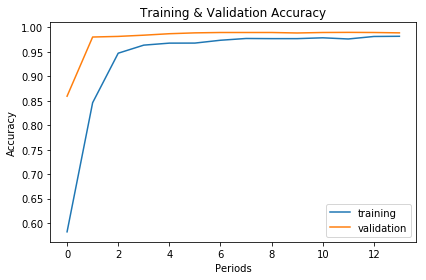

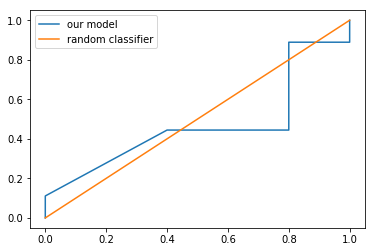

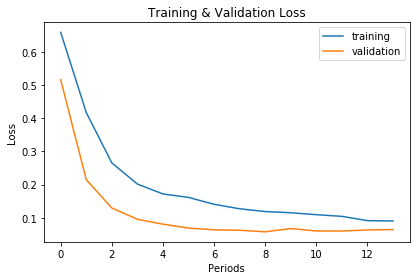

(0.989, 0.06431450146436692, 0.4666666666666667)

In [179]:
data = (training_examples, training_targets),(validation_examples, validation_targets)
train_ngram_model(data,
                      learning_rate=0.001,
                      epochs=20,
                      batch_size=64,
                      layers=4,
                      units=8,
                      dropout_rate=0.4)

In [98]:
# SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK 

In [82]:
def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index

In [83]:
def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model

In [90]:
def train_seq_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
#     num_classes = explore_data.get_num_classes(train_labels)
    num_classes = 2
#     unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
#     if len(unexpected_labels):
#         raise ValueError('Unexpected label values found in the validation set:'
#                          ' {unexpected_labels}. Please make sure that the '
#                          'labels in the validation set are in the same range '
#                          'as training labels.'.format(
#                              unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val, word_index = sequence_vectorize(
        train_texts, val_texts)
    print(x_train.shape)
    print(x_val.shape)
    
    # Create model instance.
    model = sepcnn_model(blocks=2, filters=64, kernel_size=3, embedding_dim=200, dropout_rate=dropout_rate, pool_size=3, input_shape=x_train.shape[1:], 
                         num_classes=2, num_features=min(len(word_index) + 1, TOP_K))
    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
#     print('Validation accuracy: {acc}, loss: {loss}'.format(
#             acc=history['val_acc'][-1], loss=history['val_loss'][-1]))
    
    # Compute training and validation loss.
    
    # Plot Results
    plot_res(history)
    roc_curve(history)
    auc_score = calculate_auc(history)
    
    # Save model.
    model.save('twitter_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1], auc

In [132]:
data = (training_examples, training_targets),(validation_examples, validation_targets)
train_seq_model(data,
                      learning_rate=0.001,
                      epochs=100,
                      batch_size=128,
                      layers=6,
                      units=64,
                      dropout_rate=0.4)

(10000, 86)
(1000, 86)
Train on 10000 samples, validate on 1000 samples
Epoch 1/100
 - 18s - loss: 0.6913 - acc: 0.5351 - val_loss: 0.6907 - val_acc: 0.5360
Epoch 2/100
 - 14s - loss: 0.6907 - acc: 0.5349 - val_loss: 0.6906 - val_acc: 0.5360
Epoch 3/100


KeyboardInterrupt: 